In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# FAST-PPR

I'm using the following two algorithms, excluding the DE-BIAS part of algorithm 2. They come from the paper on FAST-PPR. Unfortunately, there is a bug in our code (or our parameter choices

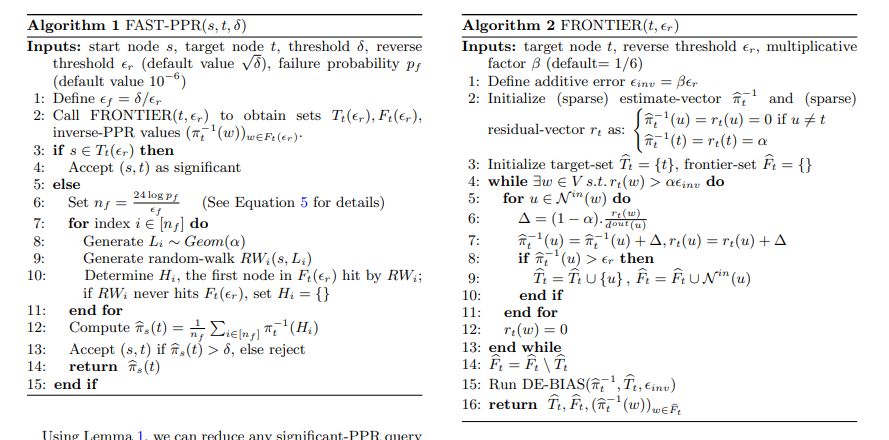

In [14]:
def FRONTIER(G,A, alpha,t,epsilon_r,beta):
    
    epsilon_inv = beta*epsilon_r
    
    # Get the number of nodes in the graph
    N = G.number_of_nodes() 
    
    # Initialise empty vectors
    pi_inv = np.zeros(N)
    r_t = np.zeros(N)
    
    # Set element t to 1 in both vectors
    pi_inv[t] = alpha
    r_t[t] = alpha
    
    # Initialiase Target set anf frontier-set
    T_t = {t}
    F_t = set()
    
    # Determine the number of nodes with r_t > alpha*epsilon_inv
    Num = len(np.where(r_t > alpha*epsilon_inv)[0])
    
    print("How many interesting nodes are there?", Num)
    
    while Num > 0:
        
        print("How many interesting nodes are there?", Num)
        
        # Set w as the first node of interest
        w = np.where(r_t > alpha*epsilon_inv)[0][0]
        
        # Get list of nodes connecting to w 
        Nbh = np.where(A[:,w] == 1)[0]
        
        
        # for-loop from paper
        for u in Nbh:
            delta = (1-alpha)*r_t[w]/sum(A[u,:]) # Replaced G.out_degree(u) by sum(A[25,:])
            pi_inv[u] += delta
            r_t[u] += delta
            
            if pi_inv[u] > epsilon_r:
                T_t.add(float(u))
                if Nbh.shape[0] > 0:
                    for i in Nbh:
                        F_t.add(float(i))
        
        r_t[w] = 0
        
        # Check how many nodes still have r_t > alpha
        Num = len(np.where(r_t > alpha*epsilon_inv)[0])
    
    # removes the items in this set that are also included in another specified set
    F_t = F_t.difference_update(T_t)
    
    return(T_t,F_t, pi_inv) # Is it ok to include all pi_inv values? Should it just be ones from the sets?

In [3]:
# Function that is given start node (s) and walk length (Li) and returns the list of visited nodes (in order)
def Random_Walk(T,s,Li,n):
        
    location = s
    
    visited = []
    visited.append(s)
    
    for step in range(Li):
        #print("Taking step", step)
        
        # Get the transition probabilities (Row of T)
        probs = T[location,:]
        
        # Generate a r.v X between 0 and 1
        X = np.random.uniform(0,1,2)
        
        
        # if X < alpha: Return to s, else choose somewhere else from probs
        if X[0] < alpha:
            #print("Returned")
            continue
        
        New_location = 0
        while(X[1] >= 0 and New_location < n-1):
            X[1] -= probs[New_location]
            New_location += 1
        
        location = New_location
        
        visited.append(location)
        
    return(visited)

In [8]:
def FAST_PPR(G,alpha,t,s,delta):
    
    # Set accuracy parameters (from paper)
    epsilon_r = np.sqrt(delta)
    p_f = 0.000006
    
    A = nx.adj_matrix(G)
    A = A.todense()
    A = np.array(A, dtype = np.float64)
    
    # Call FRONTIER function to get parameters
    T_t,F_t, pi_inv = FRONTIER(G,A,alpha,t,epsilon_r,beta)
    
    if s in T_t:
        # Accept (s,t) as significant
        
        print("(s,t) is significant")
        return( pi_inv(s) )
    
    # Get a list of graph nodes
    Nodes = list(G.nodes) # List of nodes
    N =  G.number_of_nodes() # Number of nodes
    n = G.number_of_nodes() # Number of nodes
    Pi_inv = np.zeros(N)
    
    pi_node = np.zeros(N)
    
    # Stuff for Random Walks
    A = nx.adj_matrix(G)
    A = A.todense()
    A = np.array(A, dtype = np.float64)
    n = G.number_of_nodes()
    
    # Out-Degree Vector
    D = A.sum(axis = 1)           # row-wise summation of A
    
    # Get inverse of Out-Degree Matrix (found the following lines online)
    d = np.maximum(D, np.ones(n))
    inv_d = 1.0 / d                # entry-wise division
    inv_D = np.diag(inv_d)          # convert inv_d vector to a diagonal matrix
    
    # Get the row-normalised adjacency matrix
    T = inv_D.dot(A)   # T = invD * A -- the transition matrix!
    
    
    for node in Nodes:
        print("on node", node)
        
        if (node in T_t):
            pi_node[t] = pi_inv[node] # should be returned
            
        else:
            # Set number of walks
            k = int(c*epsilon_r/delta)
            
            H = np.zeros(k)
            
            for i in range(k):
                
                # Define the length of the walk
                Li = np.random.geometric(p = alpha)
                
                H[i] = "nan" 
                
                # Generate a Random_Walk
                RW = Random_Walk(T,s, Li,n,)
                Visited_set = set(RW)
                

                if F_t != None:
                
                    if bool(set(Visited_set) & set(F_t)):
                        
                        z = Visited_set.intersection(F_t)
                        
                        # Get the first element where they met
                        for ii in RW:
                            
                            if ii in z:   
                                H[i] = ii
                                break
            count = 0                
            for i in H:

                if str(i) != 'nan':
                    count += pi_inv[i]
            
            pi_node[t] = (1/k)*count 
    return(pi_node)

In [9]:
# Generate a Random Graph G(nodes, prob of edge) (undirected)
G = nx.gnp_random_graph(1000, 0.4) 

In [21]:
# Check if FAST-PPR works

# Set Parameters (randomly)
alpha = 0.1
t = 5
s = 1
#epsilon_r = 0.1
beta = 2 # ??
delta = 0.1

# From Older paper
c = 350
beta = 1/6

FAST_PPR(G,alpha,t,s,delta)